# Mix click samples with noise samples from the recorded data

In [1]:
# all libraries used in this notebook
import sys
import os.path
from pathlib import Path
import re
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# sorting function for files and directories

def sort_key_func(file_name):
        numbers = re.findall(r'\d+', file_name)
        if numbers:
            return int(numbers[0])
        return file_name

In [3]:
# import data from selected dataset

cwd = str(Path.cwd())
parent_dir = os.path.dirname(cwd)
audio_datasets_main_dir = "01_Dataset/01_audioDatasets"
audio_datasets_main_dir = os.path.join(parent_dir, audio_datasets_main_dir)

audio_datasets = []
if os.path.exists(audio_datasets_main_dir):
    for i in os.listdir(audio_datasets_main_dir):
        #if folder name does not start with a dot
        if i[0] != ".": 
            audio_datasets.append(i)
    audio_datasets = sorted(audio_datasets)
else:
    print("Audio dataset directory does not exist")

print(audio_datasets)


['01_ethernet_without_additional_noise', '02_ethernet_with_additional_noise', '03_kombination_1_without_additional_noise', '04_kombination_1_with_additional_noise', '05_kombination_2_without_additional_noise', '06_kombination_2_with_additional_noise', '07_noise_samples', 'voice_memo_loc_mac.txt']


In [6]:
# load positive samples

dataset_num = 0 # ethernet without noise

loaded_spec_chunks = None
loaded_spec_chunk_labels = None

dataset_dir = os.path.join(audio_datasets_main_dir, audio_datasets[dataset_num])
file_list = [f for f in os.listdir(dataset_dir) if f.endswith('.npz')]
if len(file_list) == 0:
    print(f"No npz file in the directory")
else:
    for file in file_list:
        file_fullpath = os.path.join(dataset_dir, file)

        data = np.load(file_fullpath)

        if loaded_spec_chunks is None:
            loaded_spec_chunks = data['spec_chunks']
            loaded_spec_chunk_labels = data['labels']
        else:
            loaded_spec_chunks = np.concatenate((loaded_spec_chunks, data['spec_chunks']), axis=0)
            loaded_spec_chunk_labels = np.concatenate((loaded_spec_chunk_labels, data['labels']), axis=0)

print(len(loaded_spec_chunks))
print(f"positive samples: {np.count_nonzero(loaded_spec_chunk_labels == 1)}")

# create new numpy array with only positive samples

positive_sample_mask = loaded_spec_chunk_labels == 1

spec_chunks_click = loaded_spec_chunks[positive_sample_mask]
spec_chunk_labels_click = loaded_spec_chunk_labels[positive_sample_mask]

print(len(spec_chunks_click))
print(f"positive samples: {np.count_nonzero(spec_chunk_labels_click == 1)}")

print(np.max(spec_chunks_click))
print(np.min(spec_chunks_click))




11144
positive samples: 240
240
positive samples: 240
-6.131253
-136.61044


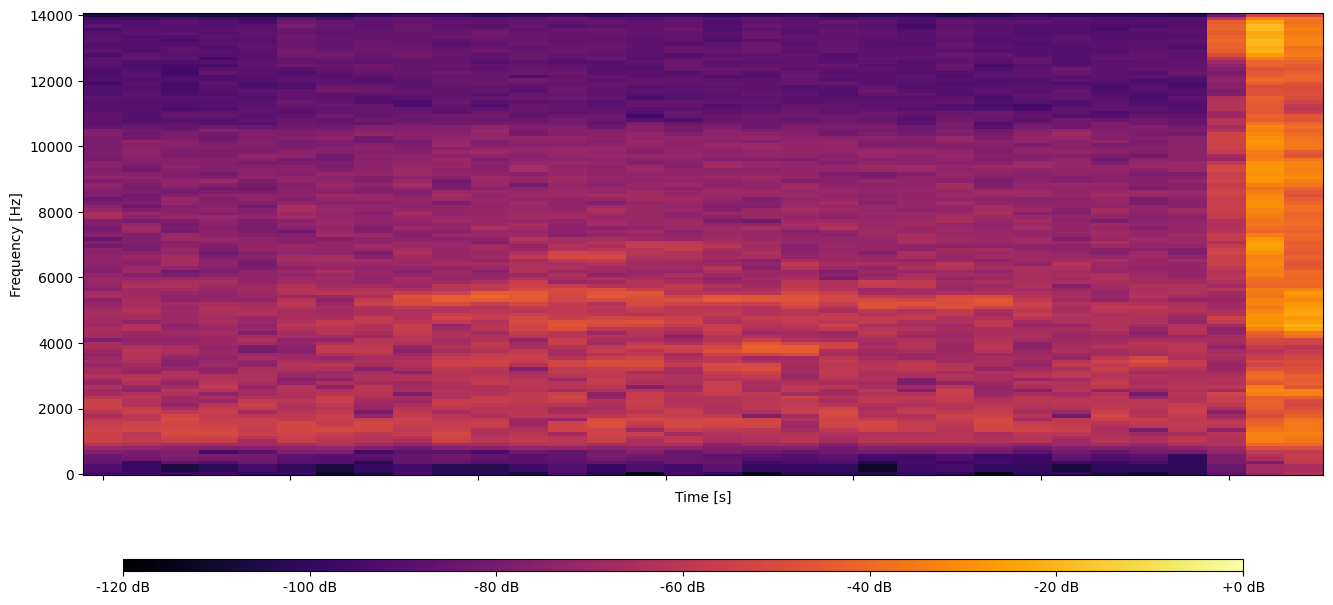

In [5]:
# plot a click mel spectrogram

chunk_id_to_plot = 0

top_dB_abs = 120
f_min = 20
f_max = 14000
n_mels = 128

def plot_mel_spectrogram(D_mel_dB, top_dB_abs, f_min, f_max, n_mels):

    fig_x = 16
    fig_y = 6
    fig, ax = plt.subplots(1, 1, figsize=(fig_x, fig_y))

    ax = plt.subplot()
    ax.set_xlabel('Time [s]')
    ax.set_ylabel('Frequency [Hz]')
    ax.axes.xaxis.set_ticklabels([]) 
    mel_spec_img = ax.pcolormesh(np.linspace(0, D_mel_dB.shape[1], D_mel_dB.shape[1]),
                                            np.linspace(f_min, f_max, n_mels), 
                                            D_mel_dB, shading='auto', cmap='inferno')

    #mel_spec_img.set_clim(vmin=-top_dB_abs, vmax=dB_ref)
    mel_spec_img.set_clim(vmin=-top_dB_abs, vmax=0)

    cbar_ax = fig.add_axes([0.15, -0.05, 0.7, 0.02])
    fig.colorbar(mel_spec_img, cax=cbar_ax, orientation='horizontal', format="%+2.0f dB")

    plt.show()

plot_mel_spectrogram(spec_chunks_click[chunk_id_to_plot], top_dB_abs, f_min, f_max, n_mels)

In [95]:
# load noise samples

dataset_num_noise = 6 # noise dataset

spec_chunks_noise = None
spec_chunk_labels_noise = None

dataset_dir_noise = os.path.join(audio_datasets_main_dir, audio_datasets[dataset_num_noise])
file_list_noise = [f for f in os.listdir(dataset_dir_noise) if f.endswith('.npz')]

print(file_list_noise)
if len(file_list_noise) == 0:
    print(f"No npz file in the directory")
else:
    for file in file_list_noise:
        file_fullpath = os.path.join(dataset_dir_noise, file)
        print(file_fullpath)

        data = np.load(file_fullpath)

        if spec_chunks_noise is None:
            spec_chunks_noise = data['spec_chunks']
            spec_chunk_labels_noise = data['labels']
        else:
            spec_chunks_noise = np.concatenate((spec_chunks_noise, data['spec_chunks']), axis=0)
            spec_chunk_labels_noise = np.concatenate((spec_chunk_labels_noise, data['labels']), axis=0)

print(len(spec_chunks_noise))
print(f"positive samples: {np.count_nonzero(spec_chunk_labels_noise == 1)}")

print(np.max(spec_chunks_noise))
print(np.min(spec_chunks_noise))

['noise_dataset.npz']
/Users/mateseidl/Library/CloudStorage/OneDrive-SZTAKI/_SZTAKI/03_Masters_thesis/01_TUM_Masterarbeit_Ausarbeitung/07_Click_event_detection_software/01_Electrical_Connector_Click-Event_Detection_git_repo/01_Dataset/01_audioDatasets/07_noise_samples/noise_dataset.npz
1192
positive samples: 0
0.0
-147.98586


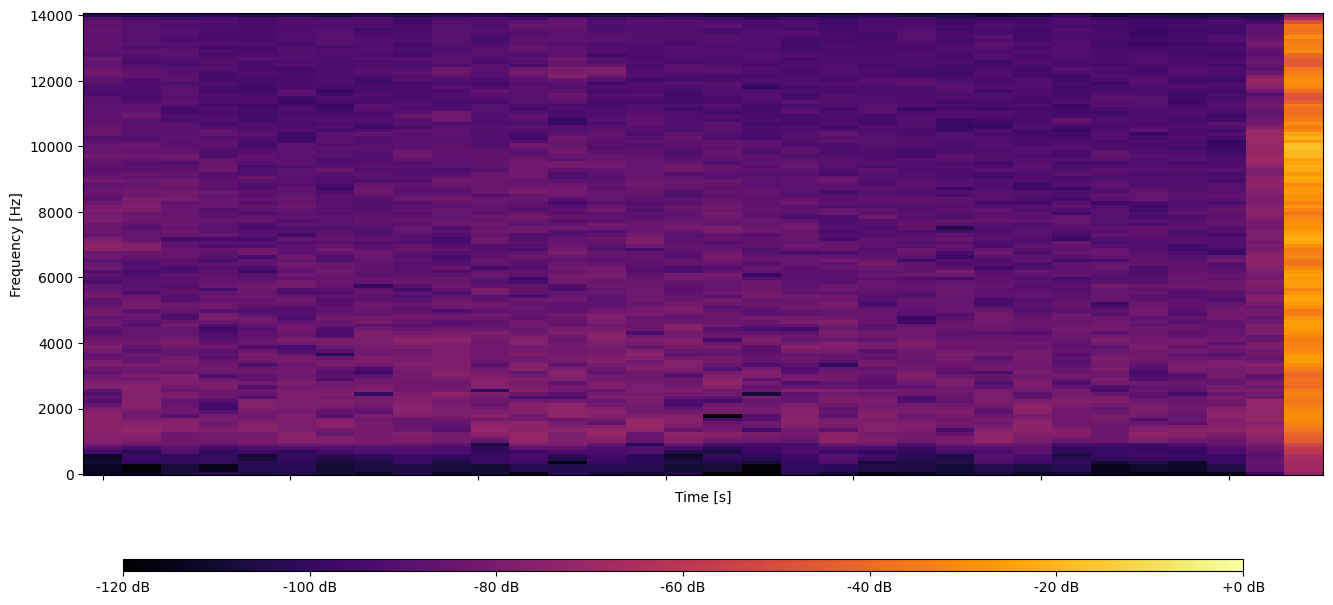

In [96]:
# plot a noise mel spectrogram

noise_chunk_id_to_plot = 0

plot_mel_spectrogram(spec_chunks_noise[noise_chunk_id_to_plot], top_dB_abs, f_min, f_max, n_mels)

In [84]:
# convert back from dB to power

# pover_mel_to_dB conversion: D_mel_dB = 10.0 * np.log10(np.maximum(a_squere_min, np.minimum(D_mel, dB_ref))/dB_ref)
# as adding two signals is possible in power domain (Roberts 1984), spectogram chunks have to be converted back first to power domain

# create a copy of spec_chunks_click
spec_chunks_click_power = np.copy(spec_chunks_click)
spec_chunks_noise_power = np.copy(spec_chunks_noise)

dB_ref = 1e3

def db_to_power_mel(D_mel_dB, dB_ref):

        D_mel = np.power(10.0, D_mel_dB/10) * dB_ref

        return D_mel

for i in range(len(spec_chunks_click_power)):
    spec_chunks_click_power[i] = db_to_power_mel(spec_chunks_click_power[i], dB_ref)

for i in range(len(spec_chunks_noise_power)):
    spec_chunks_noise_power[i] = db_to_power_mel(spec_chunks_noise[i], dB_ref)

print(len(spec_chunks_click_power))
print(np.max(spec_chunks_click_power))

print(len(spec_chunks_noise))
print(np.max(spec_chunks_noise))
print(spec_chunks_noise[0].shape)


240
243.71077
1192
0.0
(128, 32)


In [97]:
# mix ok and noise

# upsample click data to noise sample number
spec_chunks_click_power_upsampled = spec_chunks_click_power[np.random.choice(len(spec_chunks_click_power), len(spec_chunks_noise_power), replace=True)]
print(len(spec_chunks_click_power_upsampled))

np.random.shuffle(spec_chunks_click_power_upsampled)
np.random.shuffle(spec_chunks_noise_power)

spec_chunks_click_augmented_power = spec_chunks_click_power_upsampled + spec_chunks_noise_power

1192


In [98]:
# convert back to dB

spec_chunks_click_augmented_dB = np.copy(spec_chunks_click_augmented_power)

a_squere_min = 1e-12

def power_mel_to_db(D_mel, a_squere_min, dB_ref):

        D_mel_dB = 10.0 * np.log10(np.maximum(a_squere_min, np.minimum(D_mel, dB_ref))/dB_ref)

        return D_mel_dB

for i in range(len(spec_chunks_click_augmented_dB)):
    spec_chunks_click_augmented_dB[i] = power_mel_to_db(spec_chunks_click_augmented_dB[i], a_squere_min, dB_ref)

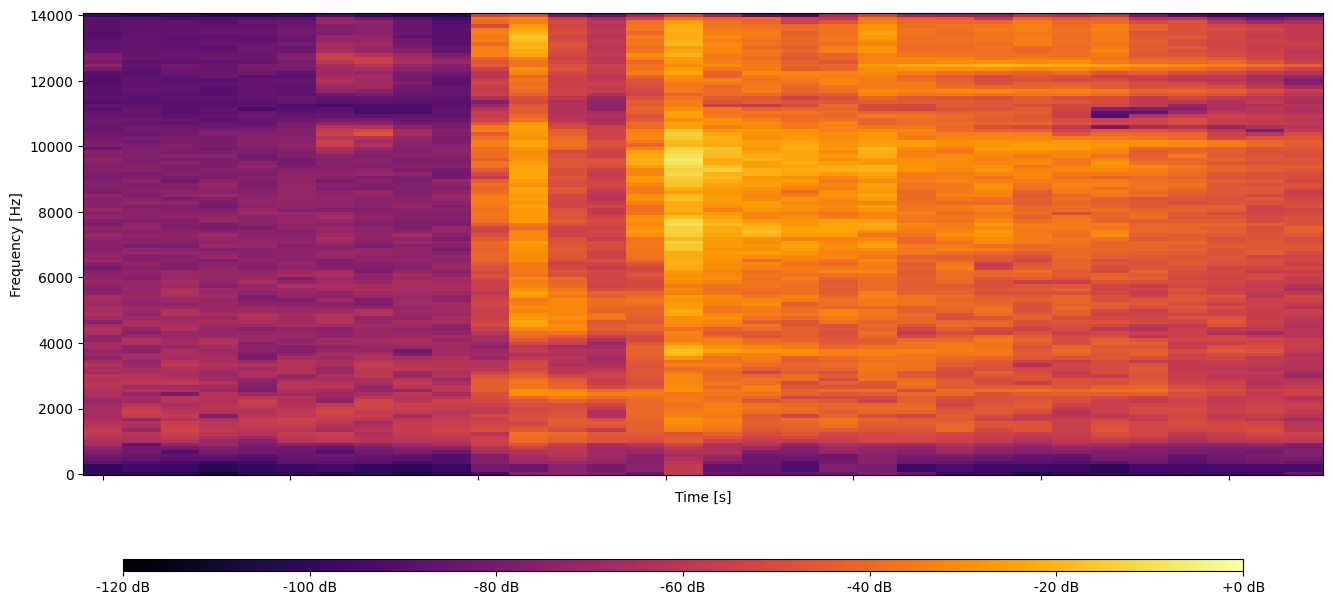

In [99]:
# plot augmented samples

augmented_chunk_id_to_plot = 2

plot_mel_spectrogram(spec_chunks_click_augmented_dB[augmented_chunk_id_to_plot], top_dB_abs, f_min, f_max, n_mels)